In [ ]:
#import libs
import torch
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
from src.models.model_zoo import TransformerWithAttentionOutputted
from src.data.MyDataset import CustomTimeSeriesDataset
from torch.utils.data import DataLoader

#load our transformer model weights
#Define model to be trained
name = "TransformerWithAttentionOutputted"
model = TransformerWithAttentionOutputted()
nettype = 'Transformer'
model.load_state_dict(torch.load(os.path.join('models', f'{name}_best_parameters.pth')))
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_test = CustomTimeSeriesDataset('ptbdb_test.csv', NetType=nettype)
#make batch size the size of the test dataset
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

#Evaluate model
model.to(device)
model.eval()  # Set best model to evaluation mode
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass and prepare for plot
        outputs, attention_weights = model(inputs)


In [91]:
np.random.seed(0)

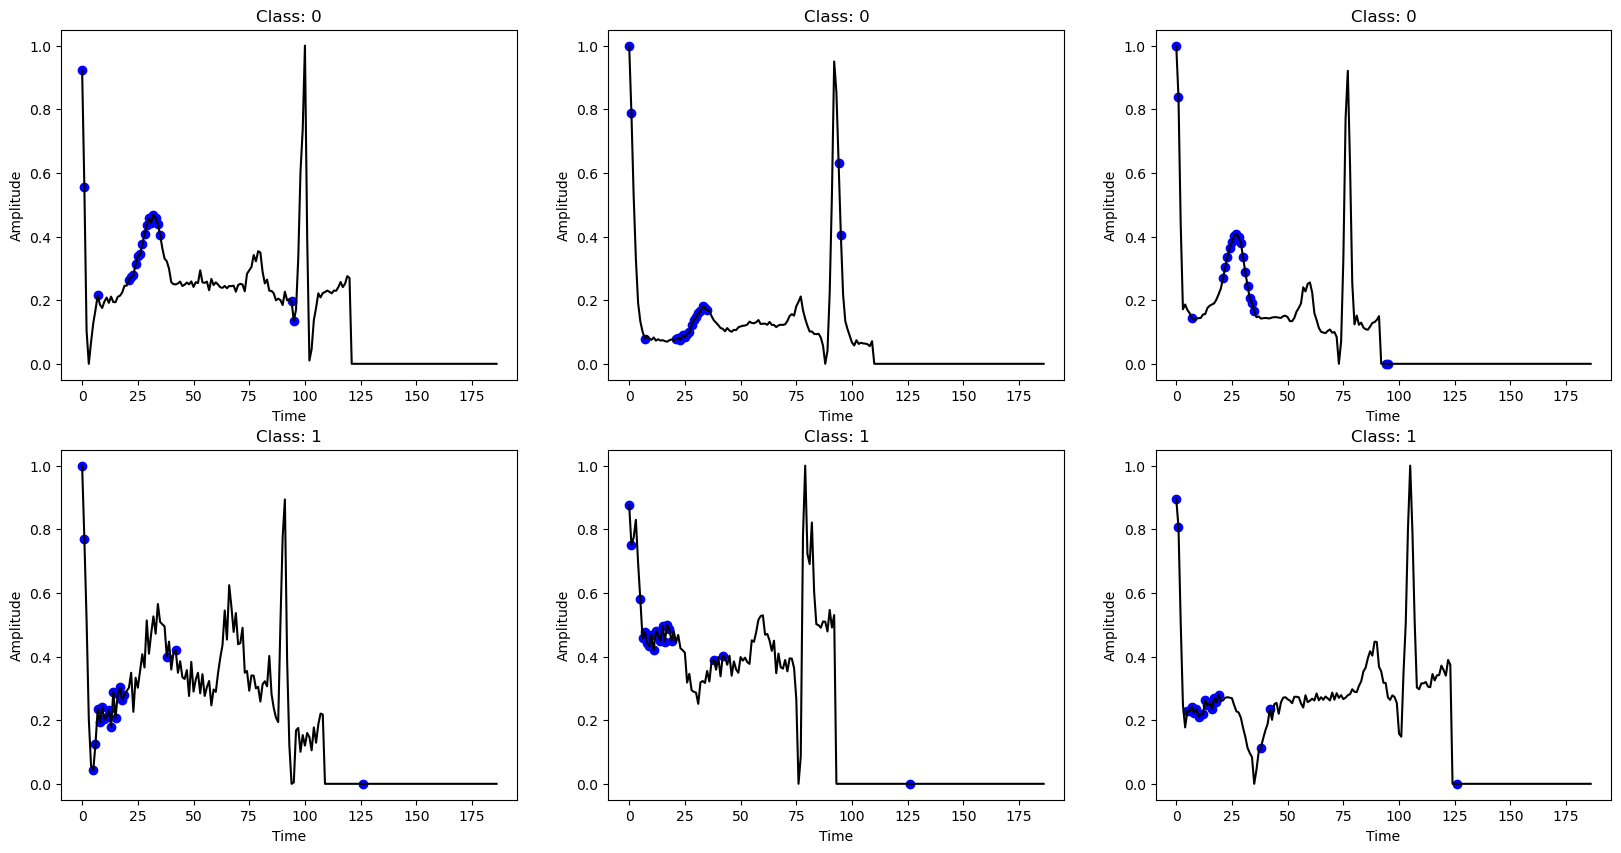

In [98]:
import numpy as np
import matplotlib.pyplot as plt

#2910x187x187
initial_weights_np =attention_weights["layer_1"].cpu().numpy()

#2910x187
average_attention_np = np.mean(initial_weights_np, axis=1)
average_attention_np = average_attention_np / np.max(average_attention_np, axis=1)[:, np.newaxis]

#2910x187
inputs_np = inputs.squeeze(1).cpu().numpy()

#2910x187
labels_np = labels.cpu().numpy()

#select 8 random samples, 4 from each class

normal_indices = np.where(labels_np == 0)[0]
abnormal_indices = np.where(labels_np == 1)[0]
normal_indices = np.random.choice(normal_indices, 4, replace=False)
abnormal_indices = np.random.choice(abnormal_indices, 4, replace=False)

#plot a few time series from both classes, use the average attention to color the points
ii = 2
jj = 3
fig, axs = plt.subplots(ii,jj, figsize=(20, 10))

#find top 20 points with higher attention in each time series
for series in average_attention_np[normal_indices]:
    top_indices_normal = np.argsort(series)[-20:]

for series in average_attention_np[abnormal_indices]:
    top_indices_abnormal = np.argsort(series)[-20:]

for i in range(ii):
    for j in range(jj):
        if i == 0:
            axs[i, j].plot(inputs_np[normal_indices[j]], color='black')
            axs[i, j].scatter(top_indices_normal, inputs_np[normal_indices[j]][top_indices_normal], color='blue')
            axs[i, j].set_title(f"Class: {0}")
            axs[i, j].set_xlabel("Time")
            axs[i, j].set_ylabel("Amplitude")

        else:
            axs[i, j].plot(inputs_np[abnormal_indices[j]], color='black')
            axs[i, j].scatter(top_indices_abnormal, inputs_np[abnormal_indices[j]][top_indices_abnormal], color='blue')
            axs[i, j].set_title(f"Class: {1}")
            axs[i, j].set_xlabel("Time")
            axs[i, j].set_ylabel("Amplitude")
